In [1]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as pl
from shapely.geometry import Point
import os
import psycopg2
import sqlite3
from shapely.wkt import loads
from shapely.geometry import Point, LineString, Polygon
import os

os.environ['SPATIALITE_SECURITY'] = 'relaxed'

In [2]:
conn = sqlite3.connect('gis.db')
conn.enable_load_extension(True)
conn.load_extension('mod_spatialite')

In [3]:
conn.execute('''
SELECT ImportSHP('gadm36_PHL_shp/gadm36_PHL_2', 'gadm', 'utf-8', 4326)
''')

In [4]:
ph = gpd.read_file('gadm36_PHL_shp/gadm36_PHL_2.shp')
ph['Province'] = ph['NAME_1']
ph['City'] = ph['NAME_2']
ph = ph[['Province','City','geometry']]
ph_LDN = ph[ph['Province'] == 'Lanao del Norte']
ph_IC = ph[ph['City'] == 'Iligan City']
ph_IC

,Province,City,geometry
793,Lanao del Norte,Iligan City,"POLYGON ((124.49559784 8.13796997, 124.4871521..."


In [5]:
import numpy as np
bng = gpd.read_file('Barangays/Barangays.shp')
bng['Province'] = bng['NAME_1']
bng['City'] = bng['NAME_2']
bng['Barangay'] = bng['NAME_3']
bng = bng[['Province','City','Barangay','geometry']]
bng_LDN = bng[bng['Province'] == 'Lanao del Norte']
bng_IC = bng[bng['City'] == 'Iligan City']
bng_IC = bng_IC[['Barangay','geometry']]
bng_IC ['Population'] = np.random.randint(3000,13000,  bng_IC.shape[0])


In [6]:
from branca.colormap import LinearColormap
colorscale1 = LinearColormap(['#FFFFFF', '#000FFF'], vmin=bng_IC['Population'].min()-1000, vmax=bng_IC['Population'].max())
colorscale1

In [7]:
# # Create connection to database with psycopg2 module (update params according your db)
connection = psycopg2.connect(host='127.0.0.1', port=5432, dbname='cyvorgz', user='cyvorgz')
# # Cursor is needed when you need to insert or make changes to the database (i.e. creating a table, index, etc)
cursor = connection.cursor()
# # Specify sql query

In [8]:

sql = "SELECT * FROM LINES"
# # replace this value with the column name of the geometry of your table
# geometry_col_name = 'way'
# # Read data from PostGIS 
# # specify the geom_col parameter if the geometry column is not called 'geom' in your table
ls = gpd.read_postgis(sql=sql, con=connection, geom_col='wkb_geometry', crs=4326)

In [9]:
import numpy as np
from branca.colormap import LinearColormap
ph_IC.loc[:, 'geometry'] = ph_IC['geometry'].simplify(0.001, preserve_topology=True) # ST_SimplifyPreserveTopology
ls['geometry'] = ls['wkb_geometry']
ic_streets = gpd.sjoin(ls,ph_IC, op='within',)
ic_streets['car_density'] = np.random.randint(0,50,  ic_streets.shape[0])
ic_streets = ic_streets[['name','geometry','car_density','other_tags']]
ic_gdf = ic_streets[['name','geometry','car_density','other_tags']]
colorscale = LinearColormap(['#33f284', '#000000'], vmin=ic_gdf['car_density'].min(), vmax=ic_gdf['car_density'].max())

/home/cyvorgz/anaconda2/envs/gsa3/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/cyvorgz/anaconda2/envs/gsa3/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [10]:
# ic_streets[ic_streets.car_density == 10]

In [11]:
crs = {'init': 'epsg:4326'}

# Create the GeoDataFrame from the DataFrame
ic_gdf = gpd.GeoDataFrame(ic_gdf, crs=crs, geometry='geometry')
ic_gdf.head()

,name,geometry,car_density,other_tags
22864,Iligan-Misamis Oriental,"LINESTRING (124.2465589 8.3229966, 124.2593193...",3,"""admin_level""=>""3"",""boundary""=>""administrative"""
35433,Tino Badelles,"LINESTRING (124.2375505 8.227547899999999, 124...",0,"""oneway""=>""no"""
35451,Macapagal Road,"LINESTRING (124.2061649 8.2042865, 124.2059826...",41,"""ref""=>""9"",""oneway""=>""yes"",""source:ref""=>""dpwh"""
35467,None,"LINESTRING (124.2437411 8.2079252, 124.2440465...",9,None
35468,Roxas Avenue,"LINESTRING (124.2412702 8.221997999999999, 124...",4,"""lanes""=>""2"",""maxspeed""=>""20"",""ref""=>""9"",""sour..."


In [12]:
def get_color(feature):
    val = feature['properties']['car_density']
    if not val:
        return '#000000'
    return colorscale(val)

In [13]:
def get_color1(feature):
    val = feature['properties']['Population']
    if not val:
        return '#000000'
    return colorscale1(val)

In [14]:

sql = "SELECT * FROM POINTS"
# # replace this value with the column name of the geometry of your table
# geometry_col_name = 'way'
# # Read data from PostGIS 
# # specify the geom_col parameter if the geometry column is not called 'geom' in your table
ps = gpd.read_postgis(sql=sql, con=connection, geom_col='wkb_geometry', crs=4326)

In [15]:
ps['geometry'] = ps['wkb_geometry']
ic_points = gpd.sjoin(ps,ph_IC, op='within',)
# ic_p['car_density'] = np.random.randint(0,50,  ic_streets.shape[0])
ic_points = ic_points[['name','geometry']]
ic_points = ic_points[['name','geometry']]
# colorscale = LinearColormap(['#33f284', '#000000'], vmin=ic_gdf['car_density'].min(), vmax=ic_gdf['car_density'].max())

In [16]:
crs = {'init': 'epsg:4326'}

# Create the GeoDataFrame from the DataFrame
ic_points = gpd.GeoDataFrame(ic_points, crs=crs, geometry='geometry')


In [17]:
# ic_points = ic_points[ic_points.name.notnull()]

In [18]:
ic_points

,name,geometry
11909,Mount Inayao,POINT (124.483333 8.316667000000001)
12583,Mount Sagada,POINT (124.416667 8.200000000000001)
13543,Junction to Barangay Suarez,POINT (124.2089263 8.2054613)
32995,None,POINT (124.2368362 8.2267715)
38259,None,POINT (124.2448231 8.239747300000001)
...,...,...
307378,Dulag,POINT (124.3894438 8.1995919)
307379,None,POINT (124.3882155 8.301121800000001)
307380,None,POINT (124.3847018 8.333168800000001)
308971,Pr Frank Tameta Residence,POINT (124.2748662 8.229588600000001)


### Testing the Search

In [19]:
### Routing

In [20]:
import numpy as np
import osmnx as ox
import networkx as nx
from sklearn.neighbors import KDTree

In [21]:
IC_poly = ph_IC['geometry'][793]

In [22]:
IC_graph = ox.graph_from_polygon(IC_poly)

In [23]:
# ic_gdf.head()

In [24]:
# ox.graph_from_polygon(ic_gdf)
# ox.

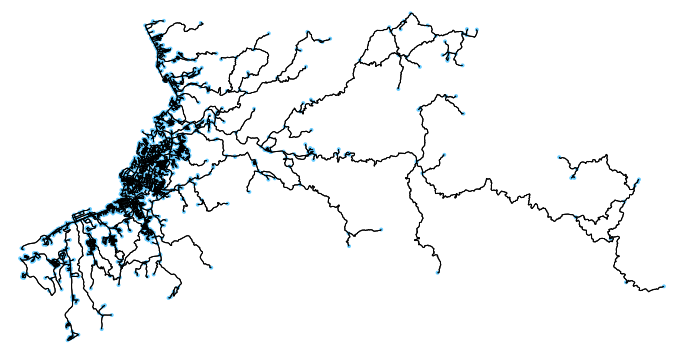

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0f7ea855f8>)

In [25]:
ox.plot_graph(IC_graph, fig_height=12, fig_width=12, edge_color="black")

In [26]:
red = [8.2261,124.2518]
# blue = [8.2190,124.2386]

In [27]:
nodes, _ = ox.graph_to_gdfs(IC_graph)
tree = KDTree(nodes[['y', 'x']], metric='euclidean')
red_idx = tree.query([red], k=3, return_distance=False)[0]
# blue_idx = tree.query([blue], k=3, return_distance=False)[0]
closest_node_to_red= nodes.iloc[red_idx].index.values[0]
# closest_node_to_blue = nodes.iloc[blue_idx].index.values[0]

In [28]:
ic_points.iloc[0,1].y

8.316667

In [29]:
lst_points = list(ic_points['geometry'])

In [30]:
# for i in lst_points:
#     i.

In [31]:
lst_closest = []

for i in lst_points:
    temp_lst = [i.y,i.x]
    idx = tree.query([temp_lst], k=3, return_distance=False)[0]
    lst_closest.append(nodes.iloc[idx].index.values[0])

In [32]:
routes = []

for point in  lst_closest:
    
    routes.append(nx.dijkstra_path(IC_graph,closest_node_to_red,point))

In [33]:
# routes = nx.single_source_shortest_path(IC_graph, closest_node_to_red)                   
# for i in lst_all_routes[::-1]:
#     ox.plot_graph_route(IC_graph, i, 
#                               edge_color="black",
#                               orig_dest_node_color="green",
#                               route_color="green")
#     #                               orig_dest_node_color="green",
#     #                               route_color="green")
# ax.scatter(red[1], red[0], c="red", s=100)
# # ax.scatter(blue[1], blue[0], c="blue", s=100)
# plt.show()

In [34]:
# routes

In [35]:
lst_all_routes = []

for key in routes.keys():
    lst_all_routes.append(routes[key])

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
# import matplotlib.pyplot as plt
# fig, ax = ox.plot_graph(IC_graph, fig_height=10, fig_width=10, 
#                         show=False, close=False, 
#                         edge_color="black")
# ax.scatter(red[1],red[0], c="red", s=100)
# ax.scatter(blue[1],blue[0], c="blue", s=100)
# plt.show()

In [ ]:
# nodes, _ = ox.graph_to_gdfs(IC_graph)
# nodes.head()

In [ ]:
# ic_streets.head(5)

In [ ]:
# line = LineString(ic_streets.geometry[35468])

# red_pt = Point(124.24127 ,8.221997)
# # 124.203149	8.171786
# line.distance(red_pt)

In [ ]:
def get_car_density(pt):
    lst = []
    for indx in ic_streets.index:
        line = ic_streets.geometry[indx]
        if line.distance(pt) < 1e-5 :
            lst.append(ic_streets.car_density[indx])
    try:
        return max(lst)
    except:
        return 0

In [ ]:
# tree = KDTree(nodes[['y', 'x']], metric='euclidean')
# red_idx = tree.query([red], k=3, return_distance=False)[0]
# blue_idx = tree.query([blue], k=3, return_distance=False)[0]
# closest_node_to_red= nodes.iloc[red_idx].index.values[0]
# closest_node_to_blue = nodes.iloc[blue_idx].index.values[0]

In [ ]:
nodes['car_density'] = nodes['geometry'].apply(lambda x: get_car_density(x))

In [ ]:
# nodes.head()

In [ ]:
lst_source = []
lst_target = []
for i in list(IC_graph.edges()):
    lst_source.append(i[0])
    lst_target.append(i[1])

In [ ]:
int(nodes[nodes['osmid']==1727291392]['car_density'])

In [ ]:
df = pd.DataFrame({'Source':lst_source,'Target':lst_target})

In [ ]:
df.head()

In [ ]:
def get_edge_cr(source,target):
    source_cr = int(nodes[nodes['osmid']==source]['car_density'])
    target_cr = int(nodes[nodes['osmid']==target]['car_density'])
    cr = (source_cr + target_cr)/2
    return cr

In [ ]:
df['Weight'] = df.apply(lambda row: get_edge_cr(row['Source'], row['Target']),axis =1)

In [ ]:
from shapely.geometry import Point, LineString, Polygon
p1 = Point(124.2518,8.2261)

In [ ]:
p1

In [ ]:
# ic_points.append(pd.Series(['City Hall', p1], index=ic_points.columns ),ignore_index=True
ic_points = ic_points.append({'name':'City Hall', 'geometry':p1} , ignore_index=True)
# Add a new row at index position 2 with values provided in list
# ic_points.iloc[808] = ['City Hall', p1]

In [ ]:
ic_points = ic_points.reset_index()

In [ ]:
ic_points = ic_points[['name','geometry']]

In [ ]:
ic_points

In [ ]:
# route = nx.dijkstra_path(IC_graph, closest_node_to_red,
#                          closest_node_to_blue)
# fig, ax = ox.plot_graph_route(IC_graph, route, fig_height=12, 
#                               fig_width=12, 
#                               show=False, close=False, 
#                               edge_color="black",
#                               orig_dest_node_color="green",
#                               route_color="green")
# ax.scatter(red[1], red[0], c="red", s=100)
# ax.scatter(blue[1], blue[0], c="blue", s=100)
# plt.show()

In [ ]:
center = [8.2427 ,124.2442] # latlng
zoom = 10
# m = folium.Map(location=center, zoom_start=zoom, prefer_canvas=True)

m = folium.Map(location = center,zoom_start=14)



fgb = folium.FeatureGroup(name="Barangays")

fgb.add_child(

folium.GeoJson(
    bng_IC,
    name = 'Population',
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Barangay', 'Population'],
        aliases=['Barangay',  'Population']
    ),
    style_function = lambda feature: {
        'fillColor': get_color1(feature),
        'color': get_color1(feature),
        

    }
)
    
)





fgp = folium.FeatureGroup(name="Streets")

fgp.add_child(

folium.GeoJson(
    ic_gdf,
    name = 'Traffic Congestion',
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'car_density'],
        aliases=['Street Name',  'car_density']
    ),
    style_function = lambda feature: {
        'fillColor': get_color(feature),
        'color': get_color(feature),
        'weight': 2,

    }
)
    
)



fgs = folium.FeatureGroup(name="Points")

for index, row in ic_points.iterrows():
#     print(row['name'])
    iframe = folium.IFrame(html= str(row['name']), width=200,height=100)
    fgs.add_child(folium.CircleMarker(location=[row['geometry'].y,row['geometry'].x], radius = 5, popup=folium.Popup(iframe),
    fill_color='white',  fill_opacity=1,))


m.add_child(fgb)
m.add_child(fgs)
m.add_child(fgp)

m.add_child(folium.LayerControl())
m.save("Map.html")

In [ ]:
# len(routes)

In [ ]:
for route in routes[:100]:
#     print(route)
#     print(route)
    # route = lst_all_routes[::-1][120]
    try:
        route_graph_map = ox.plot_route_folium(IC_graph, route, route_map=m, popup_attribute='length')
    except:
        pass

In [ ]:
route_graph_map.save('Map_Route.html')

In [ ]:
# -*- coding: utf-8 -*-

from branca.element import CssLink, Figure, JavascriptLink, MacroElement

from jinja2 import Template

from folium import Map
from folium.features import FeatureGroup, GeoJson, TopoJson
from folium.plugins import MarkerCluster
from folium.utilities import parse_options


class Search(MacroElement):
    """
    Adds a search tool to your map.
    Parameters
    ----------
    layer: GeoJson, TopoJson, FeatureGroup, MarkerCluster class object.
        The map layer to index in the Search view.
    search_label: str, optional
        'properties' key in layer to index Search, if layer is GeoJson/TopoJson.
    search_zoom: int, optional
        Zoom level to set the map to on match.
        By default zooms to Polygon/Line bounds and points
        on their natural extent.
    geom_type: str, default 'Point'
        Feature geometry type. "Point", "Line" or "Polygon"
    position: str, default 'topleft'
        Change the position of the search bar, can be:
        'topleft', 'topright', 'bottomright' or 'bottomleft',
    placeholder: str, default 'Search'
        Placeholder text inside the Search box if nothing is entered.
    collapsed: boolean, default False
        Whether the Search box should be collapsed or not.
    **kwargs.
        Assorted style options to change feature styling on match.
        Use the same way as vector layer arguments.
    See https://github.com/stefanocudini/leaflet-search for more information.
    """
    _template = Template("""
        {% macro script(this, kwargs) %}
            var {{this.layer.get_name()}}searchControl = new L.Control.Search({
                layer: {{this.layer.get_name()}},
                {% if this.search_label %}
                propertyName: '{{this.search_label}}',
                {% endif %}
                collapsed: {{this.collapsed|tojson|safe}},
                textPlaceholder: '{{this.placeholder}}',
            {% if this.geom_type == 'Point' %}
                initial: false,
                {% if this.search_zoom %}
                zoom: {{this.search_zoom}},
                {% endif %}
                position:'{{this.position}}',
                hideMarkerOnCollapse: true
            {% else %}
                marker: false,
                moveToLocation: function(latlng, title, map) {
                var zoom = {% if this.search_zoom %} {{ this.search_zoom }} {% else %} map.getBoundsZoom(latlng.layer.getBounds()) {% endif %}
                    map.flyTo(latlng, zoom); // access the zoom
                }
            {% endif %}
                });
                {{this.layer.get_name()}}searchControl.on('search:locationfound', function(e) {
                    {{this.layer.get_name()}}.setStyle(function(feature){
                        return feature.properties.style
                    })
                    {% if this.options %}
                    e.layer.setStyle({{ this.options|tojson }});
                    {% endif %}
                    if(e.layer._popup)
                        e.layer.openPopup();
                })
                {{this.layer.get_name()}}searchControl.on('search:collapsed', function(e) {
                        {{this.layer.get_name()}}.setStyle(function(feature){
                            return feature.properties.style
                    });
                });
            {{this._parent.get_name()}}.addControl( {{this.layer.get_name()}}searchControl );
        {% endmacro %}
        """)  # noqa

    def __init__(self, layer, search_label=None, search_zoom=None,
                 geom_type='Point', position='topleft', placeholder='Search',
                 collapsed=False, **kwargs):
        super(Search, self).__init__()
        assert isinstance(layer,
                          (GeoJson, MarkerCluster, FeatureGroup, TopoJson)
                          ), 'Search can only index FeatureGroup, ' \
                             'MarkerCluster, GeoJson, and TopoJson layers at ' \
                             'this time.'
        self.layer = layer
        self.search_label = search_label
        self.search_zoom = search_zoom
        self.geom_type = geom_type
        self.position = position
        self.placeholder = placeholder
        self.collapsed = collapsed
        self.options = parse_options(**kwargs)

    def test_params(self, keys):
        if keys is not None and self.search_label is not None:
            assert self.search_label in keys, "The label '{}' was not " \
                                              "available in {}" \
                                              "".format(self.search_label, keys)
        assert isinstance(self._parent, Map), "Search can only be added to " \
                                              "folium Map objects."

    def render(self, **kwargs):
        if isinstance(self.layer, GeoJson):
            keys = tuple(self.layer.data['features'][0]['properties'].keys())
        elif isinstance(self.layer, TopoJson):
            obj_name = self.layer.object_path.split('.')[-1]
            keys = tuple(self.layer.data['objects'][obj_name]['geometries'][0]['properties'].keys())  # noqa
        else:
            keys = None
        self.test_params(keys=keys)
        super(Search, self).render()

        figure = self.get_root()
        assert isinstance(figure, Figure), ('You cannot render this Element '
                                            'if it is not in a Figure.')

        figure.header.add_child(
            JavascriptLink('https://cdn.jsdelivr.net/npm/leaflet-search@2.9.7/dist/leaflet-search.min.js'),  # noqa
            name='Leaflet.Search.js'
        )

        figure.header.add_child(
            CssLink('https://cdn.jsdelivr.net/npm/leaflet-search@2.9.7/dist/leaflet-search.min.css'),  # noqa
            name='Leaflet.Search.css'
        )

In [ ]:
# -*- coding: utf-8 -*-

from branca.element import CssLink, Figure, JavascriptLink, MacroElement

from jinja2 import Template

from folium import Map
from folium.features import FeatureGroup, GeoJson, TopoJson
from folium.plugins import MarkerCluster
from folium.utilities import parse_options


class Search1(MacroElement):
    """
    Adds a search tool to your map.
    Parameters
    ----------
    layer: GeoJson, TopoJson, FeatureGroup, MarkerCluster class object.
        The map layer to index in the Search view.
    search_label: str, optional
        'properties' key in layer to index Search, if layer is GeoJson/TopoJson.
    search_zoom: int, optional
        Zoom level to set the map to on match.
        By default zooms to Polygon/Line bounds and points
        on their natural extent.
    geom_type: str, default 'Point'
        Feature geometry type. "Point", "Line" or "Polygon"
    position: str, default 'topleft'
        Change the position of the search bar, can be:
        'topleft', 'topright', 'bottomright' or 'bottomleft',
    placeholder: str, default 'Search'
        Placeholder text inside the Search box if nothing is entered.
    collapsed: boolean, default False
        Whether the Search box should be collapsed or not.
    **kwargs.
        Assorted style options to change feature styling on match.
        Use the same way as vector layer arguments.
    See https://github.com/stefanocudini/leaflet-search for more information.
    """
    _template = Template("""
        {% macro script(this, kwargs) %}
            var {{this.layer.get_name()}}searchControl = new L.Control.Search({
                layer: {{this.layer.get_name()}},
                {% if this.search_label %}
                propertyName: '{{this.search_label}}',
                {% endif %}
                collapsed: {{this.collapsed|tojson|safe}},
                textPlaceholder: '{{this.placeholder}}',
            {% if this.geom_type == 'Point' %}
                initial: false,
                {% if this.search_zoom %}
                zoom: {{this.search_zoom}},
                {% endif %}
                position:'{{this.position}}',
                hideMarkerOnCollapse: true
            {% else %}
                marker: false,
                moveToLocation: function(latlng, title, map) {
                    
                var zoom = {% if this.search_zoom %} 
                  
                {{ this.search_zoom }} {% else %} 
                map.getBoundsZoom(latlng.layer.getBounds()) {% endif %}
                
                    map.flyTo(latlng, zoom); // access the zoom
                }
            {% endif %}
                });
                {{this.layer.get_name()}}searchControl.on('search:locationfound', function(e) {
                    {{this.layer.get_name()}}.setStyle(function(feature){
                        return feature.properties.style
                    })
                    {% if this.options %}
                    e.layer.setStyle({{ this.options|tojson }});
                    {% endif %}
                    if(e.layer._popup)
                        e.layer.openPopup();
                })
                {{this.layer.get_name()}}searchControl.on('search:collapsed', function(e) {
                        {{this.layer.get_name()}}.setStyle(function(feature){
                            return feature.properties.style
                    });
                });
            {{this._parent.get_name()}}.addControl( {{this.layer.get_name()}}searchControl );
        {% endmacro %}
        """)  # noqa

    def __init__(self, layer, search_label=None, search_zoom=None,
                 geom_type='Point', position='topleft', placeholder='Search',
                 collapsed=False, **kwargs):
        super(Search1, self).__init__()
        assert isinstance(layer,
                          (GeoJson, MarkerCluster, FeatureGroup, TopoJson)
                          ), 'Search can only index FeatureGroup, ' \
                             'MarkerCluster, GeoJson, and TopoJson layers at ' \
                             'this time.'
        self.layer = layer
        self.search_label = search_label
        self.search_zoom = search_zoom
        self.geom_type = geom_type
        self.position = position
        self.placeholder = placeholder
        self.collapsed = collapsed
        self.options = parse_options(**kwargs)

    def test_params(self, keys):
        if keys is not None and self.search_label is not None:
            assert self.search_label in keys, "The label '{}' was not " \
                                              "available in {}" \
                                              "".format(self.search_label, keys)
        assert isinstance(self._parent, Map), "Search can only be added to " \
                                              "folium Map objects."

    def render(self, **kwargs):
        if isinstance(self.layer, GeoJson):
            keys = tuple(self.layer.data['features'][0]['properties'].keys())
        elif isinstance(self.layer, TopoJson):
            obj_name = self.layer.object_path.split('.')[-1]
            keys = tuple(self.layer.data['objects'][obj_name]['geometries'][0]['properties'].keys())  # noqa
        else:
            keys = None
        self.test_params(keys=keys)
        super(Search1, self).render()

        figure = self.get_root()
        assert isinstance(figure, Figure), ('You cannot render this Element '
                                            'if it is not in a Figure.')

        figure.header.add_child(
            JavascriptLink('https://cdn.jsdelivr.net/npm/leaflet-search@2.9.7/dist/leaflet-search.min.js'),  # noqa
            name='Leaflet.Search.js'
        )

        figure.header.add_child(
            CssLink('https://cdn.jsdelivr.net/npm/leaflet-search@2.9.7/dist/leaflet-search.min.css'),  # noqa
            name='Leaflet.Search.css'
        )

In [36]:
import folium
from folium import plugins
from folium.plugins import Search


center = [8.2427 ,124.2442] # latlng
zoom = 10
# m = folium.Map(location=center, zoom_start=zoom, prefer_canvas=True)

m = folium.Map(location = center,zoom_start=14)



fgb = folium.FeatureGroup(name="Barangays", show = False)

fgb.add_child(

folium.GeoJson(
    bng_IC,
    name = 'Population',
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Barangay', 'Population'],
        aliases=['Barangay',  'Population']
    ),
    style_function = lambda feature: {
        'fillColor': get_color1(feature),
        'color': get_color1(feature),
        

    }, show = False
)
    
)





fgp = folium.FeatureGroup(name="Streets")

fgp.add_child(

folium.GeoJson(
    ic_gdf,
    name = 'Traffic Congestion',
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'other_tags'],
        aliases=['Street Name', 'Description']
    ),
    style_function = lambda feature: {
        'fillColor': get_color(feature),
        'color': get_color(feature),
        'weight': 2,

    }
)
    
)



fgs = folium.FeatureGroup(name="Points",show = False)

for index, row in ic_points.iterrows():
#     print(row['name'])
    iframe = folium.IFrame(html= str(row['name']), width=200,height=100)
    fgs.add_child(folium.CircleMarker(location=[row['geometry'].y,row['geometry'].x], 
    radius = 2, popup=folium.Popup(iframe),
    fill_color='white',  fill_opacity=1,))

folium.LatLngPopup().add_to(m)

style_one = lambda x: {'fillColor': '#ffdc30'}



m.add_child(fgb)
m.add_child(fgs,)
m.add_child(fgp)

geojson_obj = folium.GeoJson(ic_points, style_function=None,name = 'Markers',show = False).add_to(m)

statesearch = Search(layer=geojson_obj,
                     geom_type='Point',
                     placeholder="Source",
                     collapsed=False,
                     search_label='name',
                     search_zoom=14,
                     position='topleft'
                    ).add_to(m)

statesearch1 = Search(layer=geojson_obj,
                      geom_type='Point',
                      placeholder="Destination",
                      collapsed=False,
                      search_label='name',
                      search_zoom=14,
                      position='topright'
                     ).add_to(m)


m.add_child(folium.LayerControl())
m.save("Map_search.html")